For pure $\alpha$_iron:  
lattice constant, elastic constants, vacancy cluster formation energies, low index surface energies, Bain path, energy-volume relations (Table S4, Fig. S4)  
phonon dispersion (3x3x3 sc)  
$\gamma$ surface

In [7]:
from pyiron import Project
import numpy as np
import matplotlib.pylab as plt
import scipy.optimize
import ase.units
import ase.build

In [8]:
potential =  'FeH-NNIP'

1. lattice constant

In [9]:
pr = Project('Fe_NNIP')

In [10]:
job = pr.create_job(job_name='lattice constant', job_type='Lammps', delete_existing_job=True)
structure = pr.create.structure.bulk('Fe', crystalstructure='bcc', cubic=True)
potential =  potential
job.structure = structure
job.potential = potential
job.calc_minimize(pressure=0.0)
job.run(delete_existing_job=True)

The job lattice_constant was saved and received the ID: 9900


In [11]:
structure_opt = job.get_structure(frame=-1)
structure_opt.get_cell()
a = np.linalg.norm(structure_opt.cell[0])
a

2.8299282001208694

2. Elastic constants

$E =  E_0 + \frac{1}{2} V \sum \epsilon_i^T C_{ij}\epsilon_j$.

The strain matrices are

$
\begin{align}
\epsilon_{11} = 
\left(
\begin{array}{ccc}
\epsilon & 0 &0 \\
0 & 0 &0 \\
0 & 0 &0 \\
\end{array}
\right)
\quad\quad
\epsilon_{22} = 
\left(
\begin{array}{ccc}
0 & 0 &0 \\
0 & \epsilon &0 \\
0 & 0 &0 \\
\end{array}
\right)
\quad\quad
\epsilon_{33} = 
\left(
\begin{array}{ccc}
0 & 0 &0 \\
0 & 0 &0 \\
0 & 0 &\epsilon \\
\end{array}
\right)\\
\epsilon_{12} = 
\left(
\begin{array}{ccc}
0 & \epsilon &0 \\
0 & 0 &0 \\
0 & 0 &0 \\
\end{array}
\right)
\quad\quad
\epsilon_{13} = 
\left(
\begin{array}{ccc}
0 & 0 &\epsilon \\
0 & 0 &0 \\
0 & 0 &0 \\
\end{array}
\right)
\quad\quad
\epsilon_{23} = 
\left(
\begin{array}{ccc}
0 & 0 &0 \\
0 & 0 &\epsilon \\
0 & 0 &0 \\
\end{array}
\right)\\
\epsilon_{21} = 
\left(
\begin{array}{ccc}
0& 0 &0 \\
\epsilon & 0 &0 \\
0 & 0 &0 \\
\end{array}
\right)
\quad\quad
\epsilon_{31} = 
\left(
\begin{array}{ccc}
0 & 0 &0 \\
0 & 0 &0 \\
\epsilon & 0 &0 \\
\end{array}
\right)
\quad\quad
\epsilon_{32} = 
\left(
\begin{array}{ccc}
0 & 0 &0 \\
0 & 0 &0 \\
0 &\epsilon &0\\
\end{array}
\right)\\
\end{align}
$

and the corresponding strain Voigt 'vectors' are

$
\begin{align}
\epsilon_1 &= (\epsilon_{11}, 0, 0, 0, 0 ,0)\\
\epsilon_2 &= (0, \epsilon_{22}, 0, 0, 0 ,0)\\
\epsilon_3 &= (0, 0, \epsilon_{33}, 0, 0 ,0)\\
\epsilon_4 &= (0, 0, 0, 2\epsilon_{23}, 0 ,0)\\
\epsilon_5 &= (0, 0, 0, 0, 2\epsilon_{13} ,0)\\
\epsilon_6 &= (0, 0, 0, 0, 0 ,2\epsilon_{12})
\end{align}
$

In general, we first compute the diagonals $C_{ii}$ by solving

$E = E_0 + \frac{1}{2} V_0 C_{ii} \epsilon_{i}\epsilon_{i}$

and then the off-diagonals,

$E = E_0 + \frac{1}{2} V_0 C_{ii} \epsilon_{i}\epsilon_{i}
+ \frac{1}{2} V_0 C_{jj} \epsilon_{j}\epsilon_{j}
+ V_0 C_{ij} \epsilon_{i}\epsilon_{j}
$


Q1: how to understand the above function (off-diagonal)

In [13]:
pr = Project("Elastic_C")

In [14]:
# structure optimization
job = pr.create.job.Lammps("optimise", delete_existing_job=True)
job.structure = pr.create.structure.bulk('Fe', crystalstructure='bcc', cubic=True)
job.potential = potential
job.calc_minimize(pressure=0.0)
job.run(delete_existing_job=True)

# get E0, V0
structure_opt = job.get_structure(frame=-1)
cell = structure_opt.get_cell()
e0   = job.output.energy_pot[-1]
v0   = structure_opt.get_volume()

The job optimise was saved and received the ID: 9901


In [15]:
strains = [-0.01, -0.005, 0.005, 0.01]
shear_strains = [0.005, 0.01, 0.015, 0.02]

I = np.diag((1, 1, 1))

def strain(e, i, j):
    voigt_map = {1:[1, 1], 2:[2, 2], 3:[3, 3],
                 4:[2, 3], 5:[1, 3], 6:[1, 2]}

    k, l = voigt_map[i]
    eps1 = np.zeros((3, 3))
    eps1[k-1][l-1] += e/2
    eps1[l-1][k-1] += e/2
    k, l = voigt_map[j]
    eps2 = np.zeros((3, 3))
    eps2[k-1][l-1] += e/2
    eps2[l-1][k-1] += e/2
    return (eps1 + eps2)/2

The job minimise was saved and received the ID: 9902
The job minimise was saved and received the ID: 9902
The job minimise was saved and received the ID: 9902
The job minimise was saved and received the ID: 9902


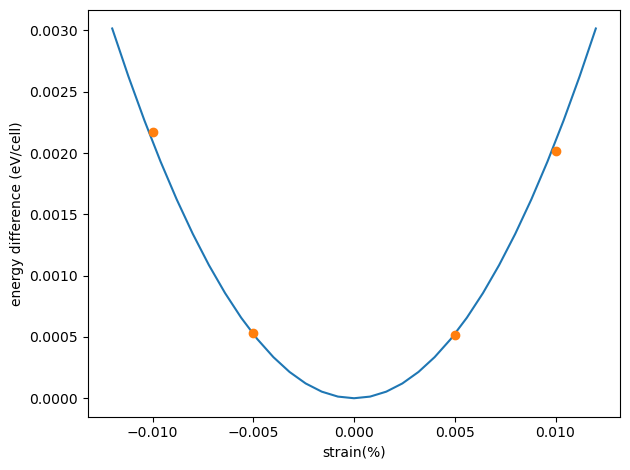

C11 = 296.12 GPa


In [39]:
# C11 calculation
data = []
for e in strains:
    D = I + strain(e, 1, 1)
    structure = structure_opt.copy()
    cell = structure_opt.get_cell()
    structure.set_cell(D.dot(cell.T).T, scale_atoms=True)
    job = pr.create.job.Lammps("minimise", delete_existing_job=True)
    job.structure = structure
    job.potential = potential
    job.calc_minimize()
    job.run(delete_existing_job=True)
    en = job.output.energy_tot[-1]
    v = structure.get_volume()
    data.append([e, v, en-e0])

E = lambda eps, C: 0.5*v0 * C * eps**2

eps, volumes, energies = zip(*data)

popt = scipy.optimize.curve_fit(E, eps, energies)
C11  = popt[0]

x = np.linspace(-eps[-1]*1.2, eps[-1]*1.2, 31)
plt.figure()
plt.plot(x, E(x, C11))
plt.plot(eps, energies, "o")
plt.xlabel("strain(%)")
plt.ylabel("energy difference (eV/cell)")
plt.tight_layout()
plt.show()

print("C11 = %.2f GPa" %(C11[0] / ase.units.kJ * 1.0e24))

In [24]:
strain(1,4,4)

array([[0. , 0. , 0. ],
       [0. , 0. , 0.5],
       [0. , 0.5, 0. ]])

The job minimise was saved and received the ID: 9902
The job minimise was saved and received the ID: 9902
The job minimise was saved and received the ID: 9902
The job minimise was saved and received the ID: 9902


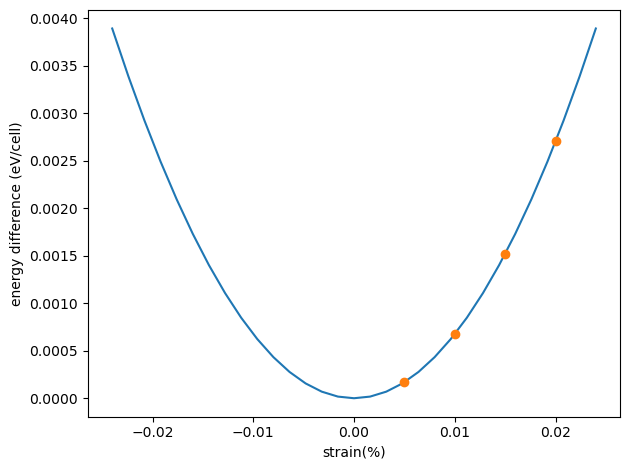

C44 = 95.56 GPa


In [69]:
# C44 calculation
data = []
for e in shear_strains:
    D = I + strain(e, 4, 4)
    structure = structure_opt.copy()
    cell = structure_opt.cell
    structure.set_cell(D.dot(cell.T).T, scale_atoms=True)
    job = pr.create.job.Lammps("minimise", delete_existing_job=True)
    job.structure = structure
    job.potential = potential
    job.calc_minimize()
    job.run(delete_existing_job=True)
    en = job.output.energy_tot[-1]
    v = structure.get_volume()
    data.append([e, v, en-e0])

E = lambda eps, C: 0.5*v0 * C * eps**2

eps, volumes, energies = zip(*data)

popt = scipy.optimize.curve_fit(E, eps, energies)
C44  = popt[0]

x = np.linspace(-eps[-1]*1.2, eps[-1]*1.2, 31)
plt.figure()
plt.plot(x, E(x, C44))
plt.plot(eps, energies, "o")
plt.xlabel("strain(%)")
plt.ylabel("energy difference (eV/cell)")
plt.tight_layout()
plt.show()

print("C44 = %.2f GPa" %(C44[0] / ase.units.kJ * 1.0e24))

The job minimise was saved and received the ID: 9902
The job minimise was saved and received the ID: 9902
The job minimise was saved and received the ID: 9902
The job minimise was saved and received the ID: 9902


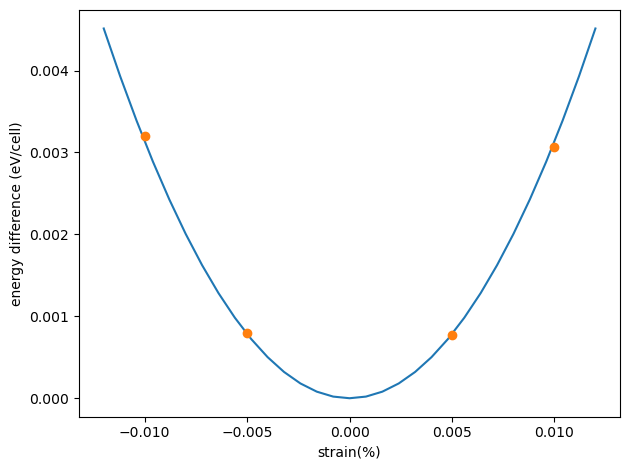

C12 = 146.99 GPa


In [87]:
# C12 calculation
# C11 = C22
data = []
for e in strains:
    D = I + strain(e, 1, 2)
    structure = structure_opt.copy()
    cell = structure_opt.cell
    structure.set_cell(D.dot(cell.T).T, scale_atoms=True)
    job = pr.create.job.Lammps("minimise", delete_existing_job=True)
    job.structure = structure
    job.potential = potential
    job.calc_minimize()
    job.run(delete_existing_job=True)
    en = job.output.energy_tot[-1]
    v = structure.get_volume()
    data.append([e, v, (en - e0)*2] )


E = lambda eps, C: 0.5 * v0 * C * eps**2

eps, volumes, energies = zip(*data)

popt = scipy.optimize.curve_fit(E, eps, energies)
C  = popt[0]

x = np.linspace(-eps[-1]*1.2, eps[-1]*1.2, 31)
plt.figure()
plt.plot(x, E(x, C))
plt.plot(eps, energies, "o")
plt.xlabel("strain(%)")
plt.ylabel("energy difference (eV/cell)")
plt.tight_layout()
plt.show()

print("C12 = %.2f GPa" %((C[0]-C11[0]) / ase.units.kJ * 1.0e24))


In [88]:
# build-in module: ElasticTensor
job_ref = pr.create.job.Lammps('reference', delete_existing_job=True)
job_ref.structure = structure_opt
job_ref.potential = potential

In [89]:
elastic = job_ref.create_job(job_type='ElasticTensor', job_name='ET', delete_existing_job=True)
elastic.run(delete_existing_job=True)

The job ET was saved and received the ID: 9903
The job ET_0 was saved and received the ID: 9904
The job ET_1 was saved and received the ID: 9905
The job ET_2 was saved and received the ID: 9906
The job ET_3 was saved and received the ID: 9907
The job ET_4 was saved and received the ID: 9908
The job ET_5 was saved and received the ID: 9909
The job ET_6 was saved and received the ID: 9910
The job ET_7 was saved and received the ID: 9911
The job ET_8 was saved and received the ID: 9912
The job ET_9 was saved and received the ID: 9913
The job ET_10 was saved and received the ID: 9914
The job ET_11 was saved and received the ID: 9915
The job ET_12 was saved and received the ID: 9916
The job ET_13 was saved and received the ID: 9917
The job ET_14 was saved and received the ID: 9918
The job ET_15 was saved and received the ID: 9919
The job ET_16 was saved and received the ID: 9920
The job ET_17 was saved and received the ID: 9921
The job ET_18 was saved and received the ID: 9922
The job ET_19

In [ ]:
elastic['output/elastic_tensor']

array([[ 2.94449227e+02,  1.46036511e+02,  1.46059792e+02,
        -2.36474067e-02,  3.48852443e-03,  1.28168846e-02],
       [ 1.46051482e+02,  2.94441203e+02,  1.46049075e+02,
        -1.48874635e-02,  1.00028929e-02,  7.97005852e-03],
       [ 1.46045438e+02,  1.46047335e+02,  2.94455712e+02,
        -1.48146290e-02,  3.95493297e-03,  9.26212851e-03],
       [ 8.71284378e-03,  3.95275173e-03,  4.28590014e-03,
         9.58147381e+01, -1.47093742e-03, -6.69330092e-03],
       [-6.38405918e-03,  3.75222855e-03, -4.11255848e-03,
        -2.64585445e-03,  9.58194140e+01,  2.65267861e-03],
       [-2.20361987e-03,  4.89330117e-03, -3.54407276e-03,
         2.93594777e-03,  2.65886916e-03,  9.58105102e+01]])

In [ ]:
elastic.input

Parameter                                              Value  \
0   min_num_measurements                                                 11   
1         min_num_points                                                105   
2             max_strain                                               0.01   
3       polynomial_order                                                  2   
4      additional_points                                                  0   
5        strain_matrices  [[[-0.009894323594443906, -0.00095342600830343...   
6           use_symmetry                                               True   
7              rotations  [[[1, 0, 0], [0, 1, 0], [0, 0, 1]], [[-1, 0, 0...   
8    normalize_magnitude                                              False   
9           use_elements                                               True   
10       fit_first_order                                              False   
11          use_pressure                                               True   

                                              Comment  
0               minimum number of samples to be taken  
1   minimum number of data points(number of measur...  
2   relative volume variation around volume define...  
3                                                      
4   number of additional linear-dependent points t...  
5   List of strain matrices (generated automatical...  
6                  Whether to consider box symmetries  
7   List of rotation matrices (generated automatic...  
8   Whether or normalize magnitude, so that the Fr...  
9   Whether or not consider chemical elements for ...  
10  Whether or not fit first order strains. In pri...  
11  Whether to use the pressure values instead of ...

3. vacancy cluster formation energies
$$E_f^v = E[n-m] + mE_{atom} - E[n]$$
$$E_f^v = E[n-m]-\frac{n-m}{n}E[n]$$

1 vacancy:

In [91]:
# 1 vacancy
pr = Project('vacancies')
E_f = []

In [92]:
bulk = pr.create.structure.bulk('Fe', crystalstructure='bcc', cubic= True)
job_bulk = pr.create.job.Lammps('bulk', delete_existing_job=True)
job_bulk.structure = bulk
job_bulk.potential = potential
job_bulk.calc_minimize(pressure=0.0)
job_bulk.run(delete_existing_job=True)

The job bulk was saved and received the ID: 9965


In [94]:
eFe = job_bulk.output.energy_tot[-1]/len(bulk)
eFe

-8.2415477862903

In [95]:
sc = pr.create.structure.bulk('Fe', crystalstructure='bcc', cubic= True).repeat([4,4,4])

In [96]:
job = pr.create.job.Lammps('opt', delete_existing_job=True)
job.structure = sc
job.potential = potential
job.calc_minimize(pressure=0.0)
job.run(delete_existing_job=True)

The job opt was saved and received the ID: 9966


In [100]:
e0 = job.output.energy_tot[-1]

In [102]:
supercell = job.get_structure(frame=-1)
supercell.get_cell()

Cell([[11.319712609528414, 6.931324907263453e-16, 6.931324907263453e-16], [0.0, 11.319712609528414, 6.931324907263452e-16], [0.0, 0.0, 11.319712609528414]])

In [110]:
supercell_1 = supercell.copy()
del supercell_1[np.random.randint(1, len(supercell)+1)]
# supercell_1.plot3d()

In [111]:
job_1 = pr.create_job('Lammps', 'sc_1', delete_existing_job=True)
job_1.structure = supercell_1
job_1.potential = potential
job_1.calc_minimize()
job_1.run(delete_existing_job=True)

The job sc_1 was saved and received the ID: 9967


Q2: job_1.calc_minimize(?)

In [112]:
e1 = job_1.output.energy_tot[-1]

In [113]:
E1 = e1 - (len(supercell_1)/len(supercell))*e0
E_f.append(E1)
E1

2.212154898179506

2 vacancies

In [115]:
# 1 NN
job_2 = pr.create.job.Lammps('v2', delete_existing_job=True)
supercell_2 = supercell.copy()
# i = np.random.randint(len(supercell))
del supercell_2[1]
del supercell_2[41]
supercell_2.plot3d()

NGLWidget()

In [116]:
job_2.structure = supercell_2
job_2.potential = potential

In [117]:
job_2.calc_minimize()
job_2.run(delete_existing_job=True)

The job v2 was saved and received the ID: 9968


In [118]:
job_2.animate_structures()

NGLWidget(max_frame=1)

In [119]:
e2 = job_2.output.energy_tot[-1]

In [120]:
E2 = e2 - len(supercell_2)/len(supercell)*e0
E_f.append(E2)
E2

4.203852636569081

In [126]:
# 2 NN
job_3 = pr.create.job.Lammps('v3')
supercell_3 = supercell.copy()
del supercell_3[1]
del supercell_3[8]
supercell_3.plot3d()

NGLWidget()

In [127]:
job_3.structure = supercell_3
job_3.potential = potential
job_3.calc_minimize()
job_3.run(delete_existing_job=True)

The job v3 was saved and received the ID: 9969


In [128]:
e3 = job_3.output.energy_tot[-1]
E3 = e3 - len(supercell_3)/len(supercell)*e0
E_f.append(E3)
E3

4.213877723758969

In [129]:
# 3 NN
job_4 = pr.create.job.Lammps('v4')
supercell_4 = supercell.copy()
del supercell_4[1]
del supercell_4[10]

job_4.structure = supercell_4
job_4.potential = potential
job_4.calc_minimize()
job_4.run(delete_existing_job=True)

e4 = job_4.output.energy_tot[-1]
E4 = e4 - len(supercell_4)/len(supercell)*e0
E_f.append(E4)
E4

The job v4 was saved and received the ID: 9970


4.47324938531915

In [130]:
# 4 NN
job_5 = pr.create.job.Lammps('v5')
supercell_5 = supercell.copy()
# i = np.random.randint(len(supercell))
del supercell_5[1]
del supercell_5[49]

job_5.structure = supercell_5
job_5.potential = potential
job_5.calc_minimize()
job_5.run(delete_existing_job=True)

e5 = job_5.output.energy_tot[-1]
E5 = e5 - len(supercell_5)/len(supercell)*e0
E_f.append(E5)
E5

The job v5 was saved and received the ID: 9971


4.407007481279152

In [131]:
# 5 NN
job_6 = pr.create.job.Lammps('v6')
supercell_6 = supercell.copy()
# i = np.random.randint(len(supercell))
del supercell_6[1]
del supercell_6[42]

job_6.structure = supercell_6
job_6.potential = potential
job_6.calc_minimize()
job_6.run(delete_existing_job=True)

e6 = job_6.output.energy_tot[-1]
E6 = e6 - len(supercell_5)/len(supercell)*e0
E_f.append(E6)
E6

The job v6 was saved and received the ID: 9972


4.398490042309049

In [132]:
E_f_NN = [2.203, 4.184, 4.183, 4.445, 4.374, 4.378]

In [141]:
for i in range(len(E_f)):
    print(E_f[i] - E_f_NN[i])

0.009154898179505988
0.019852636569081206
0.030877723758969466
0.028249385319149667
0.033007481279152096
0.020490042309049272


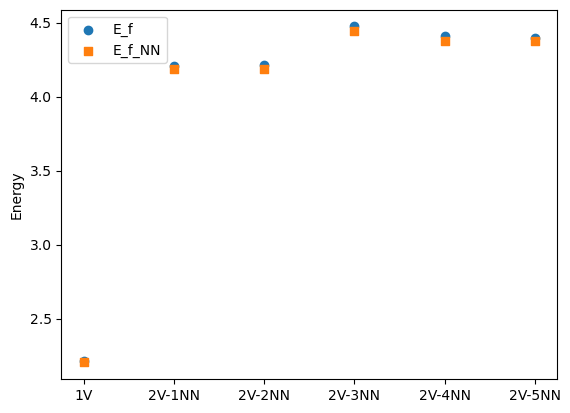

In [135]:
x_values = ['1V', '2V-1NN', '2V-2NN', '2V-3NN', '2V-4NN', '2V-5NN']

plt.scatter(x_values, E_f, label='E_f', marker='o')
plt.scatter(x_values, E_f_NN, label='E_f_NN', marker='s')

plt.ylabel('Energy')
plt.legend()

plt.show()

$1NN = \frac{\sqrt{3}}{2}a$

$2NN = a $

$3NN = \sqrt{2}a$

$4NN = \frac{\sqrt{11}}{2}a$

$5NN = \sqrt{3}a$

$6NN = 2a$

3 VACANCIES

In [144]:
list = [[0,0,0],
        [0,1,2],
        [0,1,30],
        [0,0,40],
        [0,0,8],
        [0,33,38],]

for i in list:
    print(i)

[0, 0, 0]
[0, 1, 2]
[0, 1, 30]
[0, 0, 40]
[0, 0, 8]
[0, 33, 38]


In [147]:
index = {'112': [0,0,0],
         '226': [0,1,2],
         '223': [0,1,30],
         '115': [0,0,40],
         '113': [0,0,8],
         '333': [0,33,38],
        }

for key, value in index.items():
    print(value[2])


0
2
30
40
8
38


In [152]:
E_triv = []

for key, value in index.items():
    job = pr.create.job.Lammps(job_name=f'tri-V_{key}',delete_existing_job=True)
    supercell_x = supercell.copy()
    del supercell_x[value[0]]
    del supercell_x[value[1]]
    del supercell_x[value[2]]
    job.structure = supercell_x
    job.potential = potential
    job.calc_minimize()
    job.run(delete_existing_job=True)
    ex = job.output.energy_tot[-1]
    # Ex = ex - len(supercell_x)/len(supercell)*e0
    Ex = ex + 3*eFe - e0
    E_triv.append(Ex)
    print(Ex)


The job trimV_112 was saved and received the ID: 9991
5.904890611129076
The job trimV_226 was saved and received the ID: 9992
6.210298479649055
The job trimV_223 was saved and received the ID: 9993
6.216798904348934
The job trimV_115 was saved and received the ID: 9994
6.187563331958927
The job trimV_113 was saved and received the ID: 9995
6.228175454438997
The job trimV_333 was saved and received the ID: 9996
6.738819420158961


In [153]:
E_triv_NN = [5.867, 6.146, 6.155, 6.152, 6.158, 6.665]

In [154]:
E_triv

[5.904890611129076,
 6.210298479649055,
 6.216798904348934,
 6.187563331958927,
 6.228175454438997,
 6.738819420158961]

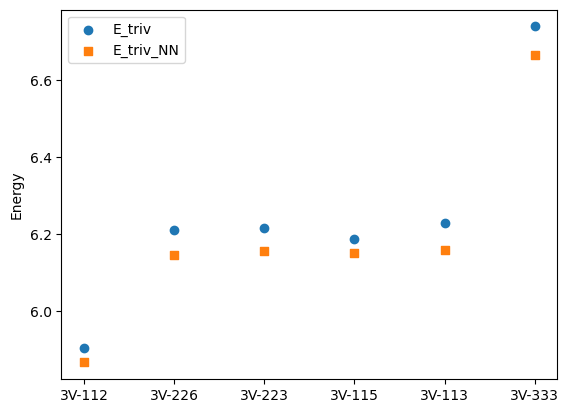

In [155]:
x_values = ['3V-112', '3V-226', '3V-223', '3V-115', '3V-113', '3V-333']

plt.scatter(x_values, E_triv, label='E_triv', marker='o')
plt.scatter(x_values, E_triv_NN, label='E_triv_NN', marker='s')

plt.ylabel('Energy')
plt.legend()

plt.show()

In [160]:
# 4 vacancies
supercell.plot3d()

NGLWidget()

In [162]:
E_q = []

supercell_qua = supercell.copy()
del supercell_qua[0]
del supercell_qua[0]
del supercell_qua[40]
del supercell_qua[40]
# supercell_qua.plot3d()

job = pr.create.job.Lammps('quadra1', delete_existing_job=True)

job.structure = supercell_qua
job.potential = potential
job.calc_minimize()
job.run(delete_existing_job=True)

eq1 = job.output.energy_tot[-1]
E = eq1 - len(supercell_qua)/len(supercell)*e0
E_q.append(E)


supercell_qua = supercell.copy()
del supercell_qua[1]
del supercell_qua[7]
del supercell_qua[7]
del supercell_qua[37]
# supercell_qua.plot3d()

job = pr.create.job.Lammps('quadra2', delete_existing_job=True)

job.structure = supercell_qua
job.potential = potential
job.calc_minimize()
job.run(delete_existing_job=True)

eq2 = job.output.energy_tot[-1]
E = eq2 - len(supercell_qua)/len(supercell)*e0
E_q.append(E)


The job quadra1 was saved and received the ID: 9997
The job quadra2 was saved and received the ID: 9998


In [164]:
E_q

[8.166877805268314, 7.32081581084833]

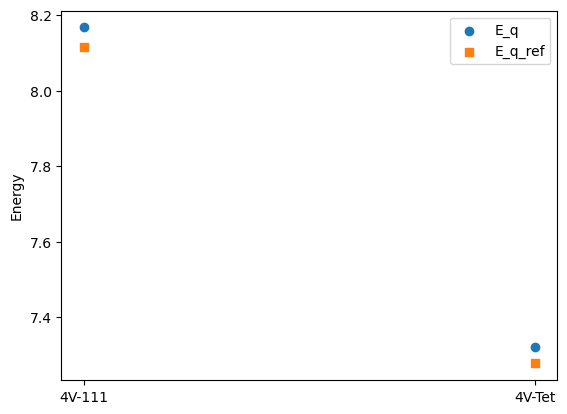

In [163]:
E_q_ref = [8.114, 7.278]

x_values = ['4V-111', '4V-Tet']

plt.scatter(x_values, E_q, label='E_q', marker='o')
plt.scatter(x_values, E_q_ref, label='E_q_ref', marker='s')

plt.ylabel('Energy')
plt.legend()

plt.show()

4. Self-interstitial energy
$$E^f = E[n+1] - E[n] - E_{atom}$$
$$E^f = E[n] - \frac{n}{n+1}E[n+1]$$

$E^f_{i-O}$

In [201]:
pr = Project('Self-interstitial')

In [202]:
E = []

In [203]:
job = pr.create.job.Lammps('minimise', delete_existing_job=True)

In [204]:
sc = pr.create.structure.bulk('Fe', crystalstructure='bcc', cubic=True).repeat([4,4,4])
job.structure = sc
job.potential = potential

In [209]:
job.calc_minimize(pressure=0.0)
job.run(delete_existing_job=True)

The job minimise was saved and received the ID: 9999


In [210]:
structure = job.get_structure(frame=-1)

In [211]:
structure.get_cell()

Cell([[11.319712609528414, 6.931324907263453e-16, 6.931324907263453e-16], [0.0, 11.319712609528414, 6.931324907263452e-16], [0.0, 0.0, 11.319712609528414]])

In [212]:
cell = structure.get_cell()

In [213]:
# adatom = pr.create.structure.atoms(['Fe'], [(2.83/2, 0, 2.83/2)], cell=cell)
adatom = pr.create.structure.atoms(['Fe'], [(2.83/4*7, 2.83/4*5, 2.83/4*7)], cell=cell)

In [214]:
structure_1 = structure.copy()
structure_1.center()
structure_1 += adatom
structure_1.plot3d()

NGLWidget()

In [215]:
job_1 = pr.create.job.Lammps('self', delete_existing_job=True)
job_1.structure = structure_1
job_1.potential = potential
job_1.calc_minimize()
job_1.run(delete_existing_job=True)

The job self was saved and received the ID: 10000


In [216]:
job_1.animate_structures()

NGLWidget(max_frame=1)

In [217]:
E_selfi = job_1.output.energy_tot[-1]

In [218]:
E_sc = job.output.energy_tot[-1]

In [219]:
E1 = E_selfi - E_sc - eFe
E.append(E1)

$E^f_{i-T}$

In [220]:
structure_2 = structure.copy()
structure_2.center()
structure_2.plot3d()

NGLWidget()

In [221]:
adatom = pr.create.structure.atoms(['Fe'], [(2.83/4*3, 2.83/4*5, 2.83/4*2+2*2.83)], cell=cell)
# adatom = pr.create_atoms(["Al"], [(2.864, 1.012, 13.728)])
structure_2 = structure.copy()
structure_2.center()
structure_2 += adatom
structure_2.plot3d()

NGLWidget()

In [222]:
job_2 = pr.create.job.Lammps('self2', delete_existing_job=True)
job_2.structure = structure_2
job_2.potential = potential
job_2.calc_minimize()
job_2.run(delete_existing_job=True)

The job self2 was saved and received the ID: 10001


In [223]:
E_selfo = job_2.output.energy_tot[-1]
# E_sc = job.output.energy_tot[-1]
E2 = E_selfo - E_sc - eFe
E.append(E2)

In [224]:
job_2.animate_structures()

NGLWidget(max_frame=1)

$E^f_{i-[110]}$ ~ dumbbells configuration

In [225]:
structure_3 = structure.copy()
# structure_3.center()
del structure_3[1]
structure_3.plot3d()

NGLWidget()

In [229]:
adatom = pr.create.structure.atoms(['Fe'], [(2.83/4*1, 2.83/2, 2.83/4*3)], cell=cell)
adatom2 = pr.create.structure.atoms(['Fe'], [(2.83/4*3, 2.83/2, 2.83/4*1)], cell=cell)
structure_3 = structure.copy()
del structure_3[1]
structure_3 += adatom
structure_3 += adatom2
structure_3.plot3d()

NGLWidget()

In [230]:
job_3 = pr.create.job.Lammps('self3', delete_existing_job=True)
job_3.structure = structure_3
job_3.potential = potential

# when set:
# job_3.calc_minimize(pressure=0.0)
# the result is consistent with the paper's

job_3.calc_minimize()
job_3.run(delete_existing_job=True)

The job self3 was saved and received the ID: 10002


In [231]:
E_self110 = job_3.output.energy_tot[-1]
# E_sc = job.output.energy_tot[-1]
E3 = E_self110 - E_sc - eFe
E.append(E3)

In [232]:
job_3.animate_structures()

NGLWidget(max_frame=1)

In [233]:
structure_4 = structure.copy()
# structure_3.center()
del structure_4[1]
structure_4.plot3d()

NGLWidget()

In [234]:
adatom = pr.create.structure.atoms(['Fe'], [(2.83/4.9*1.45, 2.83/4.9*1.45, 2.83/4.9*1.45)], cell=cell)
adatom2 = pr.create.structure.atoms(['Fe'], [(2.83/4.9*3.45, 2.83/4.9*3.45, 2.83/4.9*3.45)], cell=cell)
structure_4 = structure.copy()
del structure_4[1]
structure_4 += adatom
structure_4 += adatom2
structure_4.plot3d()

NGLWidget()

In [235]:
job_4 = pr.create.job.Lammps('self4', delete_existing_job=True)
job_4.structure = structure_4
job_4.potential = potential
job_4.calc_minimize()
job_4.run(delete_existing_job=True)

The job self4 was saved and received the ID: 10003


In [236]:
E_self111 = job_4.output.energy_tot[-1]
# E_sc = job.output.energy_tot[-1]
E4 = E_self111 - E_sc - eFe
E.append(E4)

$E^f_{i-[001]}$

In [238]:
structure_5 = structure.copy()
# structure_3.center()
del structure_5[1]
structure_5.plot3d()

NGLWidget()

In [239]:
adatom = pr.create.structure.atoms(['Fe'], [(0.145*2.83, 2.83/2, 2.83/2)], cell=cell)
adatom2 = pr.create.structure.atoms(['Fe'], [((1-0.145)*2.83, 2.83/2, 2.83/2)], cell=cell)
structure_5 = structure.copy()
del structure_5[1]
structure_5 += adatom
structure_5 += adatom2
structure_5.plot3d()

NGLWidget()

In [240]:
job_5 = pr.create.job.Lammps('self5', delete_existing_job=True)
job_5.structure = structure_5
job_5.potential = potential
job_5.calc_minimize()
# job_3.calc_minimize()
job_5.run(delete_existing_job=True)

The job self5 was saved and received the ID: 10004


In [241]:
E_self001 = job_5.output.energy_tot[-1]
# E_sc = job.output.energy_tot[-1]
E5 = E_self001 - E_sc - eFe
E.append(E5)

In [246]:
E_ref = [5.322, 4.448,  4.037, 4.744, 5.062]

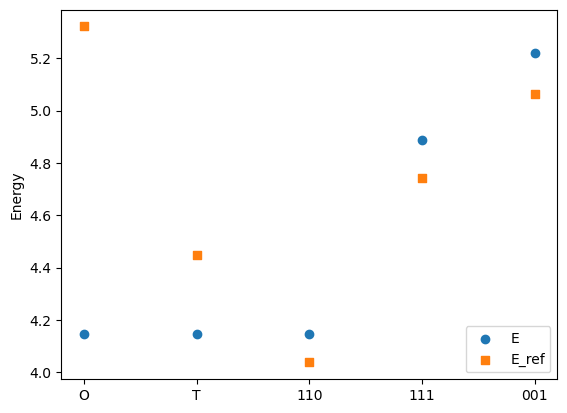

In [247]:
X = ['O', 'T', '110', '111', '001']
plt.scatter(X, E, label='E', marker='o')
plt.scatter(X, E_ref, label='E_ref', marker='s')

plt.ylabel('Energy')
plt.legend()

plt.show()

In [248]:
E

[4.145562953300201,
 4.145562952970282,
 4.145562952950273,
 4.886696285980166,
 5.221248095420139]

5. surface energy
$$\gamma = \frac{E_{slab}- n*E_{atom}}{A_{total}}$$

In [249]:
pr = Project('Surface')

In [250]:
def cal_area(structure):
    structure = structure
    V = structure.get_volume()
    c = structure.get_cell()[-1][-1]
    return V/c

In [251]:
Gamma = []

In [252]:
job_bulk = pr.create.job.Lammps('Bulk', delete_existing_job=True)
bulk = pr.create.structure.bulk('Fe', crystalstructure='bcc', cubic=True)
job_bulk.structure = bulk
job_bulk.potential = potential
job_bulk.calc_minimize(pressure=0.0)
job_bulk.run(delete_existing_job=True)
eFe = job_bulk.output.energy_tot[-1]/len(bulk)
sc = job_bulk.get_structure(-1).repeat([4,4,4])

The job Bulk was saved and received the ID: 10005


In [254]:
# 001
slab001 = pr.create.structure.surface_hkl(sc, hkl=[0,0,1],
                        layers=1, vacuum=20, center=True)
slab001.plot3d()

NGLWidget()

In [255]:
job1 = pr.create.job.Lammps('s001', delete_existing_job=True)
job1.structure = slab001
job1.potential = potential
job1.calc_minimize()
job1.run(delete_existing_job=True)
E001 = job1.output.energy_tot[-1]
# A= job1.get_structure(-1).get_volume()/job1.get_structures(-1).get_cell()[-1]
A= cal_area(job1.get_structure(-1))
gamma001 = (E001-len(slab001)*eFe)/(2*A)
Gamma.append(gamma001)

The job s001 was saved and received the ID: 10006


In [257]:
# 110
slab110 = pr.create.structure.surface_hkl(sc, hkl=[1,1,0],
                        layers=1, vacuum=20, center=True)
slab110.plot3d()

NGLWidget()

In [258]:
job2 = pr.create.job.Lammps('s110', delete_existing_job=True)
job2.structure = slab110
job2.potential = potential
job2.calc_minimize()
job2.run(delete_existing_job=True)
E110 = job2.output.energy_tot[-1]
A= cal_area(job2.get_structure(-1))
gamma110 = (E110-len(slab110)*eFe)/(2*A)
Gamma.append(gamma110)

The job s110 was saved and received the ID: 10007


In [259]:
# 111
slab111 = pr.create.structure.surface_hkl(sc, hkl=[1,1,1],
                        layers=1, vacuum=20, center=True)
slab111.plot3d()

NGLWidget()

In [260]:
job3 = pr.create.job.Lammps('s111', delete_existing_job=True)
job3.structure = slab111
job3.potential = potential
job3.calc_minimize()
job3.run(delete_existing_job=True)
E111 = job3.output.energy_tot[-1]
A= cal_area(job3.get_structure(-1))
gamma111 = (E111-len(slab111)*eFe)/(2*A)
Gamma.append(gamma111)

The job s111 was saved and received the ID: 10008


In [262]:
# 112
slab112 = pr.create.structure.surface_hkl(sc, hkl=[1,1,2],
                        layers=1, vacuum=20, center=True)
slab112.plot3d()

NGLWidget()

In [263]:
job4 = pr.create.job.Lammps('s112', delete_existing_job=True)
job4.structure = slab112
job4.potential = potential
job4.calc_minimize()
job4.run(delete_existing_job=True)
E112 = job4.output.energy_tot[-1]
A= cal_area(job4.get_structure(-1))
gamma112 = (E112-len(slab112)*eFe)/(2*A)
Gamma.append(gamma112)

The job s112 was saved and received the ID: 10009


In [264]:
Gamma_ref = [2.479, 2.436, 2.695, 2.586]

In [265]:
Gamma

[0.15443004124033569,
 0.15138275433696582,
 0.16967877076576895,
 0.16897186351337523]

In [266]:
Gamma1 = [x /ase.units.J * (ase.units.m)**2 for x in Gamma]
Gamma1

[2.4742420162444567, 2.4254190979099643, 2.718553595669975, 2.7072276929413834]

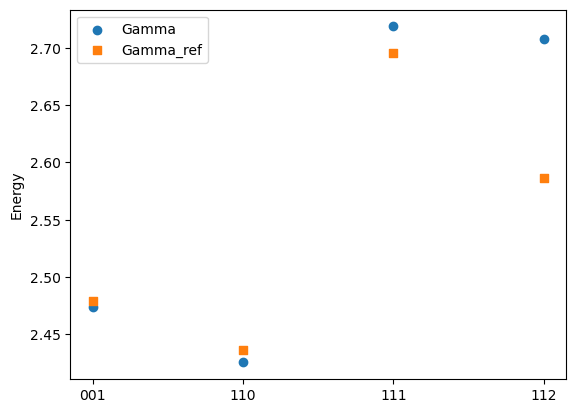

In [267]:
x_values = ['001', '110', '111', '112']

plt.scatter(x_values, Gamma1, label='Gamma', marker='o')
plt.scatter(x_values, Gamma_ref, label='Gamma_ref', marker='s')

plt.ylabel('Energy')
plt.legend()

plt.show()

In [ ]:
job.calc_md?

Signature:
job.calc_md(
    temperature=None,
    pressure=None,
    n_ionic_steps=1000,
    time_step=1.0,
    n_print=100,
    temperature_damping_timescale=100.0,
    pressure_damping_timescale=1000.0,
    seed=None,
    tloop=None,
    initial_temperature=None,
    langevin=False,
    delta_temp=None,
    delta_press=None,
)
Docstring:
Set an MD calculation within LAMMPS. Nosé Hoover is used by default.

Args:
    temperature (None/float/list): Target temperature value(-s). If set to None, an NVE
        calculation is performed. It is required when the pressure is set or langevin is set
        It can be a list of temperature values, containing the initial target temperature and
        the final target temperature (in between the target value is varied linearly).
    pressure (None/float/numpy.ndarray/list): Target pressure. If set to None, an NVE or an
        NVT calculation is performed. If set to a scalar, the shear of the cell and the
        ratio of the x, y, and z compone

6. Bain path

In [268]:
pr = Project('Bain_path')

In [269]:
bulk = pr.create.structure.bulk('Fe', crystalstructure='bcc', cubic=True)

In [270]:
bulk.get_cell()

Cell([2.87, 2.87, 2.87])

In [272]:
job = pr.create.job.Lammps('minimise', delete_existing_job=True)
job.structure = bulk
job.potential = potential
job.calc_minimize(pressure=0.0)
job.run(delete_existing_job=True)
structure = job.get_structure(-1)
cell = structure.get_cell()
E = job.output.energy_tot[-1]/len(structure)
E

The job minimise was saved and received the ID: 10010


-8.2415477862903

In [273]:
cell

Cell([[2.8299282001208694, 1.7328312560474265e-16, 1.7328312560474265e-16], [0.0, 2.8299282001208694, 1.7328312560474263e-16], [0.0, 0.0, 2.8299282001208694]])

In [274]:
ratio = np.arange(0.8, 2.0, 0.05)
deltaE = []
# R = [1/np.power(x, 1/3) for x in ratio]

In [275]:
for x in ratio:
    job = pr.create.job.Lammps('energy', delete_existing_job=True)
    bulk = structure.copy()
    cell_change = cell.copy()
    matrix = np.zeros((3, 3))
    np.fill_diagonal(matrix, [1/np.power(x, 1/3), 1/np.power(x, 1/3), np.power(x, 1/3)**2])
    bulk.set_cell(cell_change*matrix, scale_atoms=True)
    job.structure = bulk
    job.potential = potential
    job.calc_minimize()
    job.run(delete_existing_job=True)
    print('current volume: ',job.get_structure(-1).get_volume())
    e = job.output.energy_tot[-1]/len(bulk)
    deltaE.append(e-E)

The job energy was saved and received the ID: 10011
current volume:  22.663461928943267
The job energy was saved and received the ID: 10011
current volume:  22.663461929070483
The job energy was saved and received the ID: 10011
current volume:  22.66346192833458
The job energy was saved and received the ID: 10011
current volume:  22.663461929106987
The job energy was saved and received the ID: 10011
current volume:  22.6634619292773
The job energy was saved and received the ID: 10011
current volume:  22.66346192891555
The job energy was saved and received the ID: 10011
current volume:  22.66346192881932
The job energy was saved and received the ID: 10011
current volume:  22.66346192901573
The job energy was saved and received the ID: 10011
current volume:  22.663461928729113
The job energy was saved and received the ID: 10011
current volume:  22.663461929415085
The job energy was saved and received the ID: 10011
current volume:  22.663461929195424
The job energy was saved and received 

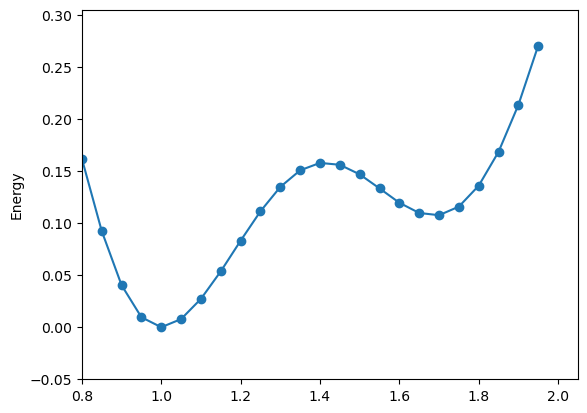

In [276]:
plt.plot(ratio, deltaE, marker='o')
plt.ylabel('Energy')
# plt.legend()
plt.xlim(0.8, 2.05)
plt.ylim(-0.05, 0.305)
plt.show()

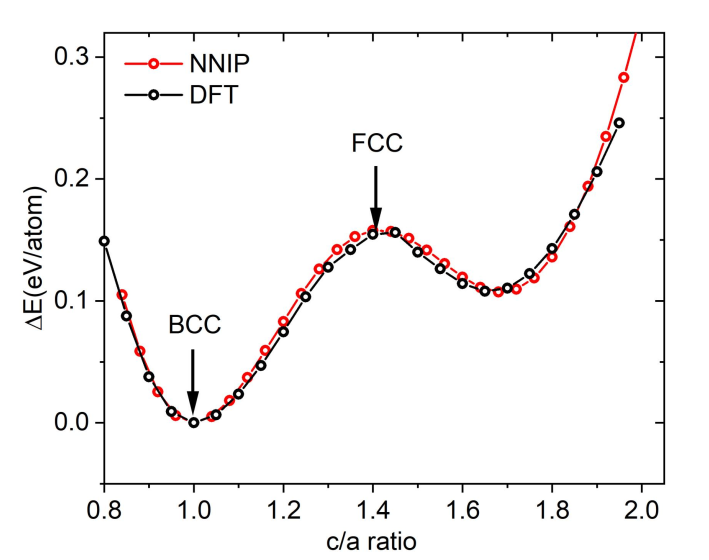

7. energy-volume relations (Table S4, Fig. S4)  

In [277]:
pr = Project('energy-volume')

In [278]:
# bcc
job = pr.create.job.Lammps('minimise', delete_existing_job=True)
job.structure = pr.create.structure.bulk('Fe', crystalstructure='bcc', cubic=True)
job.potential = potential
job.calc_minimize(pressure=0.0)
job.run(delete_existing_job=True)
structure = job.get_structure(-1)
cell = structure.get_cell()
e0 = job.output.energy_tot[-1]/len(structure)

The job minimise was saved and received the ID: 10012


In [279]:
strains = np.linspace(0.90, 1.10, 9)**(1/3.)
volumes_bcc = []
energies_bcc = []

In [280]:
for s in strains:
    bulk = structure.copy()
    bulk.set_cell(s*cell, scale_atoms=True)
    job = pr.create.job.Lammps('bcc', delete_existing_job=True)
    job.structure = bulk
    job.potential = potential
    job.calc_minimize()
    job.run(delete_existing_job=True)
    e = job.output.energy_tot[-1]/len(bulk)
    v = job.get_structure(-1).get_volume()/len(bulk)
    energies_bcc.append(e-e0)
    volumes_bcc.append(v)

The job bcc was saved and received the ID: 10013
The job bcc was saved and received the ID: 10013
The job bcc was saved and received the ID: 10013
The job bcc was saved and received the ID: 10013
The job bcc was saved and received the ID: 10013
The job bcc was saved and received the ID: 10013
The job bcc was saved and received the ID: 10013
The job bcc was saved and received the ID: 10013
The job bcc was saved and received the ID: 10013


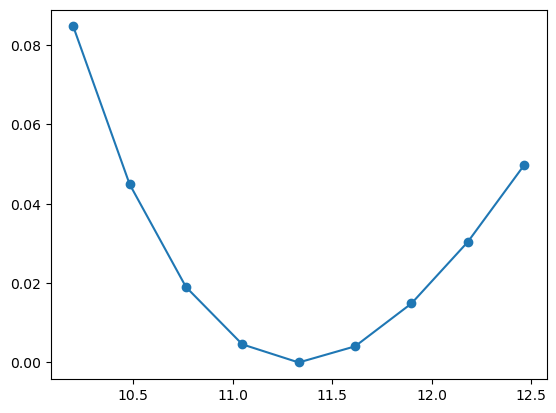

In [281]:
plt.plot(volumes_bcc, energies_bcc, marker='o')
# plt.ylabel('Energy')
# plt.legend()
plt.show()

In [282]:
# fcc
fcc = pr.create.structure.bulk('Fe', crystalstructure='fcc', a = 3.66, cubic=True)
job = pr.create.job.Lammps('fcc',delete_existing_job=True)
job.structure = fcc
job.potential = potential
job.calc_minimize(pressure=0)
job.run(delete_existing_job=True)
structure = job.get_structure(-1)

The job fcc was saved and received the ID: 10014


In [283]:
strains = np.linspace(0.90, 1.10, 9)**(1/3.)
volumes_fcc = []
energies_fcc = []

for s in strains:
    bulk = structure.copy()
    cell = bulk.get_cell()
    bulk.set_cell(s*cell, scale_atoms=True)
    job = pr.create.job.Lammps('fcc', delete_existing_job=True)
    job.structure = bulk
    job.potential = potential
    job.calc_minimize()
    job.run(delete_existing_job=True)
    e = job.output.energy_tot[-1]/len(bulk)
    v = job.get_structure(-1).get_volume()/len(bulk)
    energies_fcc.append(e-e0)
    volumes_fcc.append(v)

The job fcc was saved and received the ID: 10014
The job fcc was saved and received the ID: 10014
The job fcc was saved and received the ID: 10014
The job fcc was saved and received the ID: 10014
The job fcc was saved and received the ID: 10014
The job fcc was saved and received the ID: 10014
The job fcc was saved and received the ID: 10014
The job fcc was saved and received the ID: 10014
The job fcc was saved and received the ID: 10014


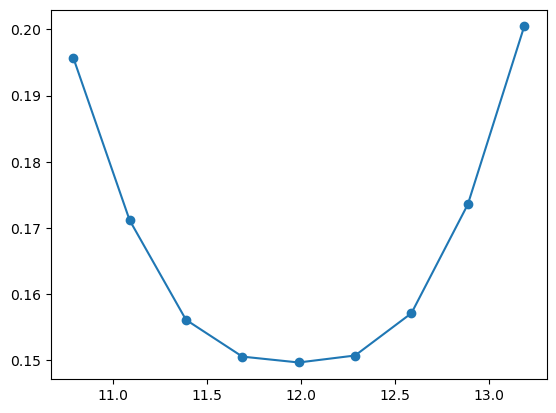

In [284]:
plt.plot(volumes_fcc, energies_fcc, marker='o')
# plt.ylabel('Energy')
# plt.legend()
plt.show()

In [285]:
# hcp
hcp = pr.create.structure.bulk('Fe', crystalstructure='hcp', a = 2.43, c= 3.84)
job = pr.create.job.Lammps('hcp', delete_existing_job=True)
job.structure = hcp
job.potential = potential
job.calc_minimize(pressure=0)
job.run(delete_existing_job=True)
structure = job.get_structure(-1)

The job hcp was saved and received the ID: 10015


In [286]:
strains = np.linspace(0.90, 1.10, 9)**(1/3.)
volumes_hcp = []
energies_hcp = []

for s in strains:
    bulk = structure.copy()
    cell = bulk.get_cell()
    bulk.set_cell(s*cell, scale_atoms=True)
    job = pr.create.job.Lammps('hcp', delete_existing_job=True)
    job.structure = bulk
    job.potential = potential
    job.calc_minimize()
    job.run(delete_existing_job=True)
    e = job.output.energy_tot[-1]/len(bulk)
    v = job.get_structure(-1).get_volume()/len(bulk)
    energies_hcp.append(e-e0)
    volumes_hcp.append(v)

The job hcp was saved and received the ID: 10015
The job hcp was saved and received the ID: 10015
The job hcp was saved and received the ID: 10015
The job hcp was saved and received the ID: 10015
The job hcp was saved and received the ID: 10015
The job hcp was saved and received the ID: 10015
The job hcp was saved and received the ID: 10015
The job hcp was saved and received the ID: 10015
The job hcp was saved and received the ID: 10015


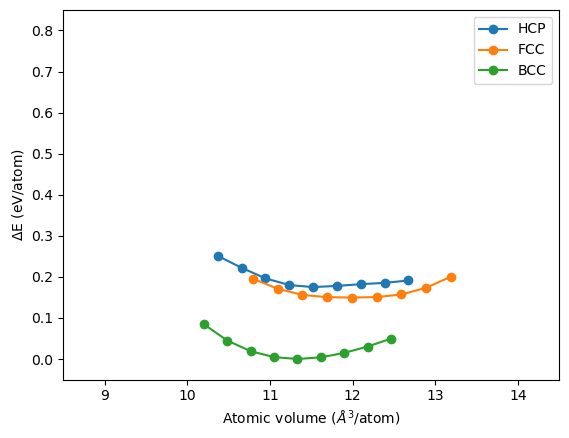

In [287]:
plt.plot(volumes_hcp, energies_hcp, marker='o', label='HCP')
plt.plot(volumes_fcc, energies_fcc, marker='o', label='FCC')
plt.plot(volumes_bcc, energies_bcc, marker='o', label='BCC')
plt.ylim(-0.05, 0.85)
plt.xlim(8.5, 14.5)
plt.xlabel(r'Atomic volume ($\AA^3$/atom)')
plt.ylabel(r'$\Delta$E (eV/atom)')
plt.legend()
plt.show()

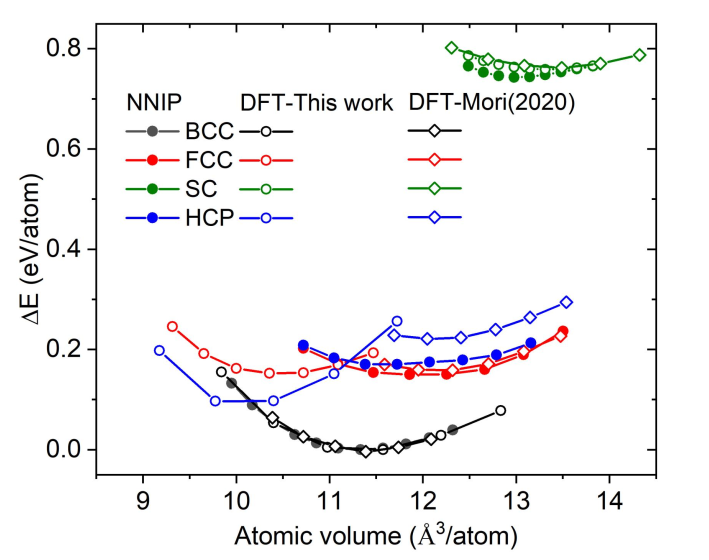

SC?

deformation of hcp???

8. phonon dispersion (3x3x3 sc)  

In [303]:
pr = Project("Phonon")

min_job = pr.create.job.Lammps("min_job", delete_existing_job=True)
min_job.structure = pr.create.structure.ase.bulk("Fe", cubic=True).repeat([3,3,3])
min_job.potential = potential
min_job.calc_minimize(pressure=0.0)
min_job.run(delete_existing_job=True)

job = pr.create.job.Lammps("ref_job", delete_existing_job=True)
job.structure = min_job.get_structure(-1)
job.potential = potential

ha = pr.create.job.PhonopyJob("ha_job",  delete_existing_job=True)
ha.ref_job = job
ha.run(delete_existing_job=True)

The job min_job was saved and received the ID: 10030
The job ha_job was saved and received the ID: 10031
The job ref_job_0 was saved and received the ID: 10032


In [304]:
ha.input

Parameter      Value  \
0    interaction_range  10.000000   
1               factor  15.633302   
2         displacement   0.010000   
3             dos_mesh  20.000000   
4     primitive_matrix        NaN   
5  number_of_snapshots        NaN   

                                             Comment  
0                     Minimal size of supercell, Ang  
1  Frequency unit conversion factor (default for ...  
2                            atoms displacement, Ang  
3                      mesh size for DOS calculation  
4                                                     
5  int or None, optional. Number of snapshots of ...

<Axes: title={'center': 'Bandstructure'}, xlabel='Bandpath', ylabel='Frequency [THz]'>

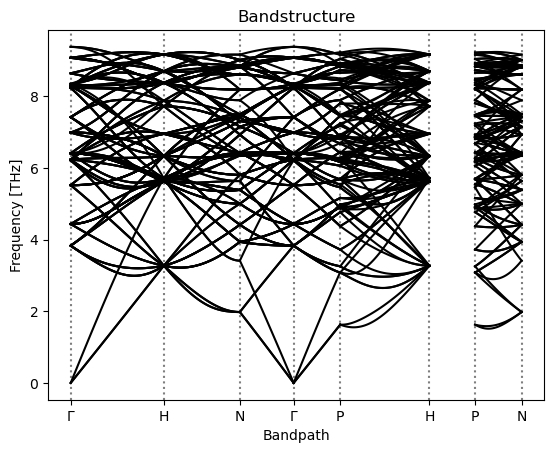

In [289]:
# ha.plot_dos()
ha.plot_band_structure()

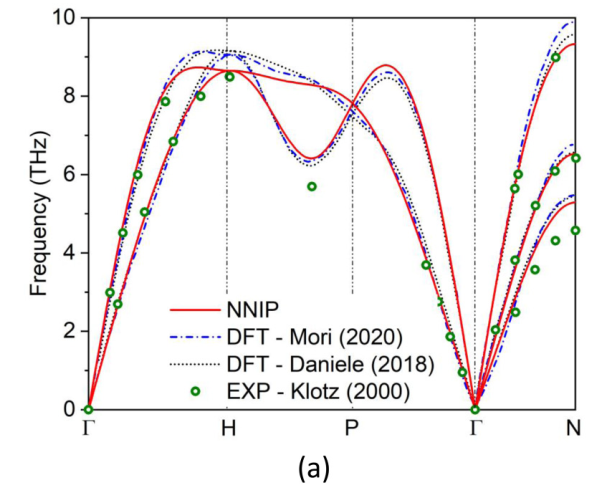

In [290]:
# tp = ha.get_thermal_properties()
# plt.plot(tp.temperatures, tp.free_energies)

In [291]:
pr = Project("Phonon")

min_job = pr.create.job.Lammps("min_job", delete_existing_job=True)
min_job.structure = pr.create.structure.ase.bulk("Fe", cubic=True)
min_job.potential = potential
min_job.calc_minimize(pressure=0.0)
min_job.run(delete_existing_job=True)

job = pr.create.job.Lammps("ref_job", delete_existing_job=True)
job.structure = min_job.get_structure(-1)
job.potential = potential

ha = pr.create.job.PhonopyJob("ha_job",  delete_existing_job=True)
ha.ref_job = job
ha.run(delete_existing_job=True)

The job min_job was saved and received the ID: 10019
The job ha_job was saved and received the ID: 10020
The job ref_job_0 was saved and received the ID: 10021


<Axes: title={'center': 'Bandstructure'}, xlabel='Bandpath', ylabel='Frequency [THz]'>

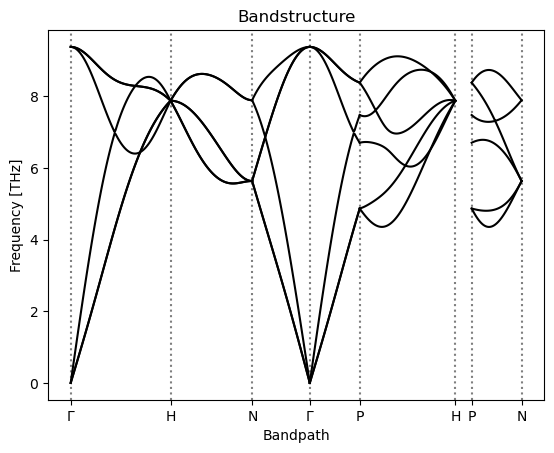

In [292]:
# ha.plot_dos()
ha.plot_band_structure()

9. $\gamma$ surface

10. GBs

In [293]:
pr = Project("grain_boundaries")
pr.create.structure.aimsgb.build?

Signature:
pr.create.structure.aimsgb.build(
    axis,
    sigma,
    plane,
    initial_struct,
    to_primitive=False,
    delete_layer='0b0t0b0t',
    add_if_dist=0.0,
    uc_a=1,
    uc_b=1,
)
Docstring:
Generate a grain boundary structure based on the aimsgb.GrainBoundary module.

Args:
    axis : Rotational axis for the GB you want to construct (for example, axis=[1,0,0])
    sigma (int) : The sigma value of the GB you want to construct (for example, sigma=5)
    plane: The grain boundary plane of the GB you want to construct (for example, plane=[2,1,0])
    initial_struct : Initial bulk structure from which you want to construct the GB (a pyiron
                    structure object).
    delete_layer : To delete layers of the GB. For example, delete_layer='1b0t1b0t'. The first
                   4 characters is for first grain and the other 4 is for second grain. b means
                   bottom layer and t means top layer. Integer represents the number of layers
              

In [294]:
bulk = pr.create.structure.bulk('Fe', cubic=True)
job_min = pr.create.job.Lammps('minimise', delete_existing_job=True)
job_min.structure = bulk
job_min.potential = potential
job_min.calc_minimize(pressure=0.0)
job_min.run(delete_existing_job=True)
eFe = job_min.output.energy_tot[-1]/len(bulk)
structure = job_min.get_structure(-1)

The job minimise was saved and received the ID: 10022


In [301]:
# 110 symmetric
gb1 = pr.create.structure.aimsgb.build((1,1,0), 9, (-1,1,-4), structure,
                                      uc_a=1, uc_b=1, add_if_dist=1)
gb2 = pr.create.structure.aimsgb.build((1,1,0), 11, (1,-1,3), structure,
                                      uc_a=1, uc_b=1, add_if_dist=1)
gb3 = pr.create.structure.aimsgb.build((1,1,0), 3, (1,-1,2), structure,
                                      uc_a=1, uc_b=1, add_if_dist=1)
gb4 = pr.create.structure.aimsgb.build((1,1,0), 3, (-1,1,1), structure,
                                      uc_a=1, uc_b=1, add_if_dist=1)
gb5 = pr.create.structure.aimsgb.build((1,1,0), 11, (-3,3,2), structure,
                                      uc_a=1, uc_b=1, add_if_dist=1)
gb6 = pr.create.structure.aimsgb.build((1,1,0), 9, (-2,2,1), structure,
                                      uc_a=1, uc_b=1, add_if_dist=1)
gb7 = pr.create.structure.aimsgb.build((1,1,0), 27, (-5,5,2), structure,
                                      uc_a=1, uc_b=1, add_if_dist=1)

In [310]:
GBs = [gb1, gb2, gb3, gb4, gb5, gb6, gb7]
E = []
i=1
for gb in GBs:
    job = pr.create.job.Lammps(f'gb{i}', delete_existing_job=True)
    job.structure = gb
    job.potential = potential
    job.calc_minimize()
    job.run(delete_existing_job=True)
    i+=1
    a,b,c = job.get_structure(-1).get_cell()
    A = np.linalg.norm(np.cross(a,b))
    e = job.output.energy_tot[-1]
    egb = (e-len(gb)*eFe) / (2*A)
    print(len(gb))
    e_gb = egb / ase.units.J * (ase.units.m)**2
    E.append(e_gb)

The job gb1 was saved and received the ID: 10039
104
The job gb2 was saved and received the ID: 10040
68
The job gb3 was saved and received the ID: 10041
40
The job gb4 was saved and received the ID: 10042
20
The job gb5 was saved and received the ID: 10043
136
The job gb6 was saved and received the ID: 10044
52
The job gb7 was saved and received the ID: 10045
216


In [312]:
E

[0.15488821400849428,
 0.20606566334692691,
 0.26825195796271456,
 0.43114674389352975,
 0.18239382283095765,
 0.2898736816589423,
 0.18449030911714628]

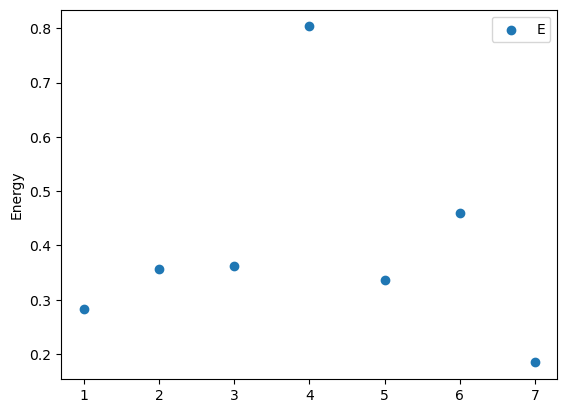

In [306]:
x_values = ['1', '2', '3', '4', '5', '6', '7']

plt.scatter(x_values, E, label='E', marker='o')

# plt.plt.ylim(0, 2.1)
# plt.plt.xlim(-5, 15)
plt.ylabel('Energy')
plt.legend()

plt.show()

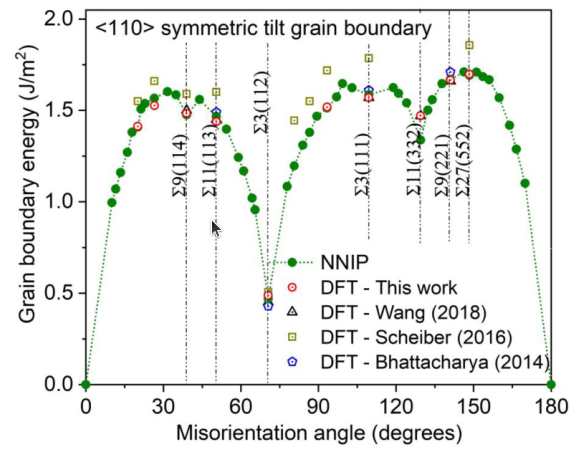

In [308]:
# 001 symmetric
gb1 = pr.create.structure.aimsgb.build((0,0,1), 13, (5,-1,0), structure,
                                      uc_a=1, uc_b=1, add_if_dist=1)

gb2 = pr.create.structure.aimsgb.build((0,0,1), 17, (4,1,0), structure,
                                      uc_a=1, uc_b=1, add_if_dist=1)

gb3 = pr.create.structure.aimsgb.build((0,0,1), 5, (3,-1,0), structure,
                                      uc_a=1, uc_b=1, add_if_dist=1)

gb4 = pr.create.structure.aimsgb.build((0,0,1), 5, (2,-1,0), structure,
                                      uc_a=1, uc_b=1, add_if_dist=1)

gb5 = pr.create.structure.aimsgb.build((0,0,1), 17, (5,3,0), structure,
                                      uc_a=1, uc_b=1, add_if_dist=1)

gb6 = pr.create.structure.aimsgb.build((0,0,1), 13, (3,-2,0), structure,
                                      uc_a=1, uc_b=1, add_if_dist=1)

In [309]:
GBs_001 = [gb1, gb2, gb3, gb4, gb5, gb6]
E_001 = []
i=1
for gb in GBs_001:
    job = pr.create.job.Lammps(f'gb001_{i}', delete_existing_job=True)
    job.structure = gb
    job.potential = potential
    job.calc_minimize()
    job.run(delete_existing_job=True)
    i+=1
    a,b,c = job.get_structure(-1).get_cell()
    A = np.linalg.norm(np.cross(a,b))
    e = job.output.energy_tot[-1]
    egb = (e-len(gb)*eFe) / (2*A)
    e_gb = egb / ase.units.J * (ase.units.m)**2
    E_001.append(e_gb)

The job gb001_1 was saved and received the ID: 10033
The job gb001_2 was saved and received the ID: 10034
The job gb001_3 was saved and received the ID: 10035
The job gb001_4 was saved and received the ID: 10036
The job gb001_5 was saved and received the ID: 10037
The job gb001_6 was saved and received the ID: 10038


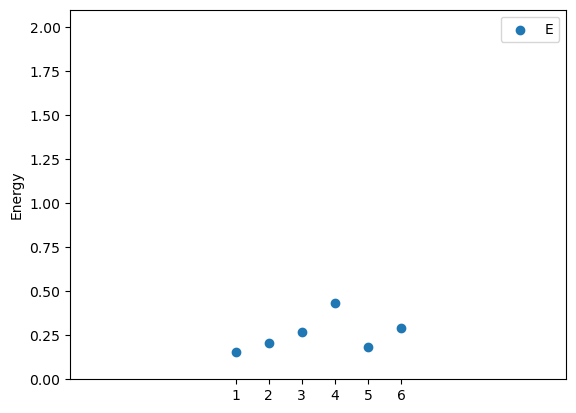

In [ ]:
x_values = ['1', '2', '3', '4', '5', '6']
# Ex = [x*2 for x in E_110]

plt.scatter(x_values, E_001, label='E', marker='o')

plt.plt.ylim(0, 2.1)
plt.plt.xlim(-5, 10)
plt.ylabel('Energy')
plt.legend()

plt.show()

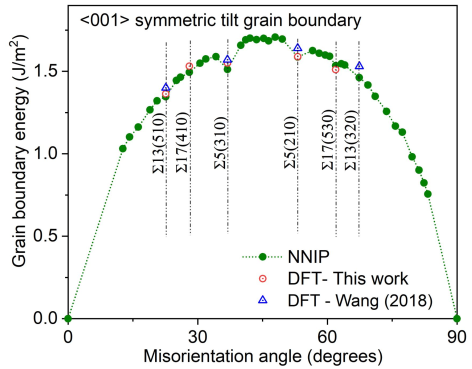

In [ ]:
from pyscal3 import System

In [ ]:
sys = System.create.defect.grain_boundary(axis=[1,1,0],
                        sigma=9,
                        gb_plane=[-1, -1, -4],
                        element='Fe')
sys.show.all()

TypeError: GB cannot be created with the given input!

In [ ]:
from atomrdf import System, KnowledgeGraph

In [ ]:
kg = KnowledgeGraph()
struct_gb_2 = System.create.defect.grain_boundary(axis=[1,1,0],
                        sigma=9,
                        gb_plane=[2, 2, 1],
                        element='Fe',
                        graph=kg)

TypeError: GB cannot be created with the given input!

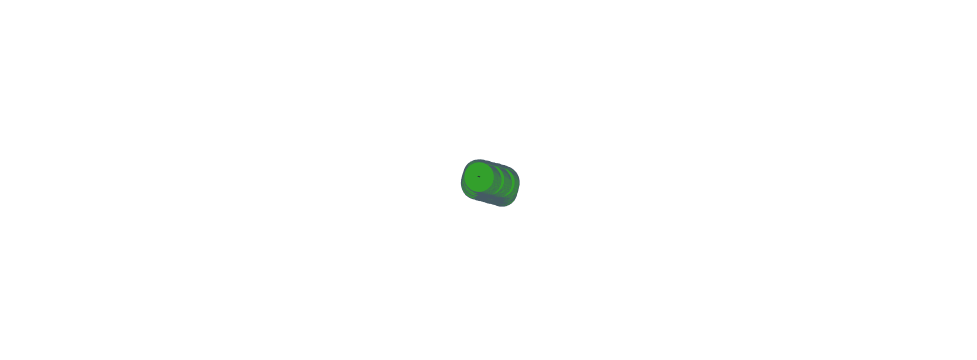

In [ ]:
struct_gb_2.show.all()

1. stacking fault
2. easy core, hard core, and split core in dislocation
fig.S5


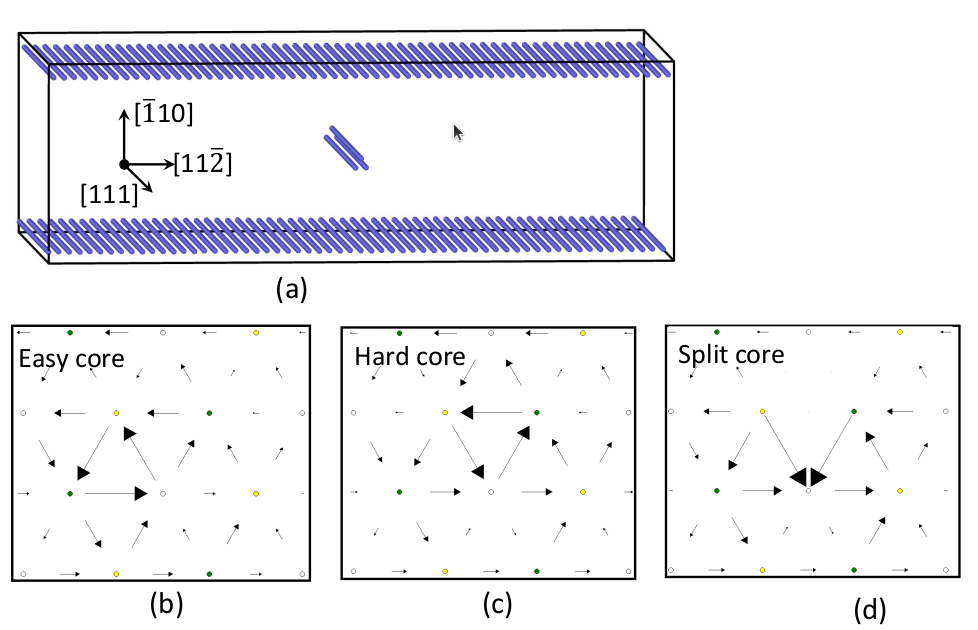


In [314]:
from atomrdf import System, KnowledgeGraph
import numpy as np


In [315]:
burgers_vector = 0.5*np.array([1, 0, -1])
slip_vector = np.array([1, 1, 1])
dislocation_line = np.array([1, 0, -1])


In [316]:
elastic_constant_dict = {'C11': 169, 'C12': 122, 'C44': 75.4}

In [317]:
sys = System.create.defect.dislocation(burgers_vector,
                                      slip_vector,
                                      dislocation_line,
                                      elastic_constant_dict,
                                      element='Cu',
                                      dislocation_type='periodicarray')

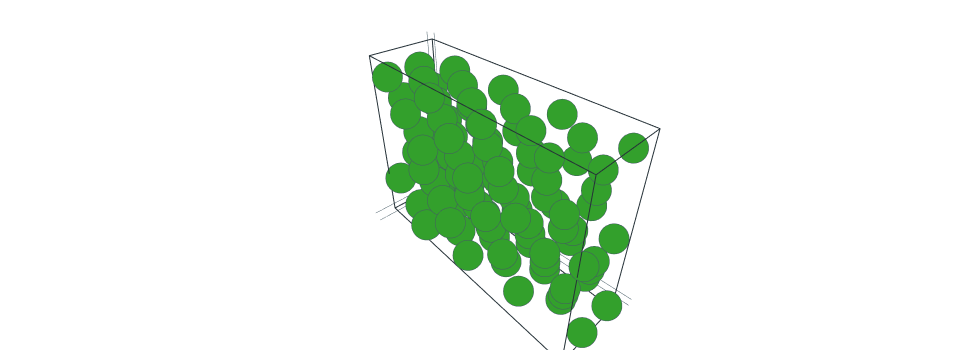

In [318]:
sys.show.all()